## **SETUP**

In [1]:
from fastai.vision.all import *
set_seed(2023)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
trn_path = '/kaggle/input/zindidata/images'
files = get_image_files(trn_path) 
files

(#34731) [Path('/kaggle/input/zindidata/images/images/ab79912e70d6f5cd30f6cf58c31c9ea9025a210f.jpg'),Path('/kaggle/input/zindidata/images/images/66afa71daaa249fbc84d26e0f0d4d1335f7e4040.jpg'),Path('/kaggle/input/zindidata/images/images/4419ac5729cffeb5b2e02cbcb8183b2cfe323254.jpg'),Path('/kaggle/input/zindidata/images/images/78a69baedd896a2ca96ed0f63fd284b3d8ddbbd1.jpg'),Path('/kaggle/input/zindidata/images/images/49010135b36a2ad6e815a7382d1b2d8458dbe8da.jpg'),Path('/kaggle/input/zindidata/images/images/837423c8155c5de12394e13aaa020efa6ea12049.jpg'),Path('/kaggle/input/zindidata/images/images/8d5781f32f86a728b38bbbd74bcf7aa1187c0a61.jpg'),Path('/kaggle/input/zindidata/images/images/e623543fbe025f8a27d04a7938aa6d969dd57dce.jpg'),Path('/kaggle/input/zindidata/images/images/b7e0d2b32652fec3607a2cec24d8290026131f53.jpg'),Path('/kaggle/input/zindidata/images/images/e06c9ae5fdc29b0c277a376d07e69de6e1dafe11.jpg')...]

(320, 240)


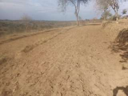

In [3]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [4]:
Train            = pd.read_csv('/kaggle/input/zindidata/Train.csv')
Test             = pd.read_csv('/kaggle/input/zindidata/Test.csv')
SampleSubmission = pd.read_csv('/kaggle/input/zindidata/SampleSubmission.csv')

In [5]:
Train.damage.value_counts()

damage
G        11623
WD        9238
DR        4516
other      419
ND         272
Name: count, dtype: int64

In [6]:
from fastcore.parallel import *
def f(o): return PILImage.create(o).size
# sizes = parallel(f, files, n_workers=8)
# pd.Series(sizes).value_counts()

In [7]:
damage = Train.damage.unique()

In [8]:
Train.head(2)

,ID,damage,filename
0,ID_UBHORS,WD,d036341be8d6cd59851cb80bcc9a70cc9fbdba30.jpg
1,ID_9DSOLZ,G,9ea16180c50d0cd539897eefbfe585314e50a56b.jpg


In [10]:
def train(arch, item, batch, epoch = 5):

    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock(vocab=damage)),
                           get_x = ColReader('filename', pref = '/kaggle/input/zindidata/images/images/'),
                           get_y = ColReader('damage'),
                           splitter = RandomSplitter(valid_pct = 0.25, seed = 47),
                           item_tfms = item, #Resize(320, method = 'squish'),
                           batch_tfms = batch, #aug_transforms(size = 128, min_scale = 0.75)
                          )

    dls = dblock.dataloaders(Train)
    #dls.show_batch(max_n = 6)
    learn = vision_learner(dls, arch, loss_func = nn.CrossEntropyLoss(), metrics=accuracy).to_fp16()
    learn.fine_tune(epoch, 0.015)
    
    return learn

In [11]:
learn = train('convnext_small_in22k', Resize(320, method = 'squish'), aug_transforms(size = 224, min_scale = 0.7), epoch = 5)

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.037483,0.857118,0.664876,13:31


epoch,train_loss,valid_loss,accuracy,time
0,0.799191,0.897284,0.630965,14:19
1,0.737964,0.712807,0.703391,14:09
2,0.646905,0.652336,0.733006,14:12
3,0.562753,0.617425,0.749425,14:13
4,0.488685,0.618790,0.749118,14:11


In [12]:
test_dl = learn.dls.test_dl('/kaggle/input/zindidata/images/images/' + Test['filename'])
# preds , _ = learn.get_preds(dl=test_dl)
preds , _ = learn.tta(dl=test_dl)

In [13]:
preds = F.softmax(preds, dim=1)

In [14]:
submission_sf = pd.DataFrame({
    
    'ID': Test['ID'],
    'DR': preds[:, 0].squeeze().numpy(),
    'G' : preds[:, 1].squeeze().numpy(),
    'ND': preds[:, 2].squeeze().numpy(),
    'WD': preds[:, 3].squeeze().numpy(),
    'other': preds[:, 4].squeeze().numpy(),
})

In [15]:
submission_sf.head(50)

,ID,DR,G,ND,WD,other
0,ID_QW9GQM,1.130318e-03,0.458654,7.337880e-05,0.539406,7.363204e-04
1,ID_G9VPQ9,2.137125e-02,0.796390,6.736677e-03,0.057382,1.181202e-01
2,ID_QIMIEM,4.529385e-06,0.469668,5.488585e-08,0.530258,7.018010e-05
3,ID_TSINUQ,9.614741e-04,0.614492,2.110217e-05,0.383742,7.837751e-04
4,ID_I7OOHH,7.151836e-02,0.726254,3.142531e-03,0.196418,2.667357e-03
5,ID_QG9HRD,8.746045e-02,0.887426,2.487363e-04,0.024529,3.356113e-04
6,ID_4H8KV9,6.017970e-03,0.227226,4.441438e-03,0.759995,2.319426e-03
7,ID_QG7V9L,7.584772e-02,0.145289,9.482236e-03,0.759963,9.418211e-03
8,ID_JD7LXZ,9.349015e-02,0.652983,4.984674e-03,0.245148,3.394277e-03
9,ID_SHOLMQ,8.182950e-03,0.936515,7.033984e-05,0.052066,3.165996e-03


In [16]:
Train.damage.value_counts()

damage
G        11623
WD        9238
DR        4516
other      419
ND         272
Name: count, dtype: int64

In [17]:
submission_sf.to_csv('baseline_sub_3.csv', index=False)

In [18]:
submission_sf.to_csv('baseline_sub_3_tta.csv', index=False)